# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
# jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 3133
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)

SLURM_ARRAY_TASK_ID: 3133


In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.delta_obs = truth['obs'] - 1
model.block()
# model.render()

# CONFIG
{'a_lpt': 0.5,
 'a_obs': 0.5,
 'box_shape': array([320., 320., 320.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
               

2025-01-31 16:23:18.228437: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
theme()
ils = pload(save_path+"_init_last_state.p").z
ls = pload(save_path+"_last_state.p").z # .z for numpyro, .position for blackjax
# ls = pload(save_path+"_last_state.p").position # .z, .position
# ls = pload(save_path+"_last_state.p")['mesh_'].position

mesh0 = jnp.fft.irfftn(truth['init_mesh'])
init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(43), mcmc_config['n_chains']))
print(init_params_.keys(), ils.keys(), ls.keys())

kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
kptcs = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ls)
kpk0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
kpkobs = model.spectrum(truth['obs']-1)

mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
mse = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ls)['init_mesh']  - mesh0)**2, axis=(1,2,3))
print("MSEs:", mse__, mse_, mse)

prob = 0.95
log = False
plt.figure(figsize=(12, 4))
plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), log=log, label='init')
plot_powtranscoh(*kptcs__, log=log, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), log=log, label='warm')
plot_powtranscoh(*kptcs_, log=log, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs), 1), log=log, label='last')
plot_powtranscoh(*kptcs, log=log, fill=prob)
plt.subplot(131)
plot_pow(*kpk0, 'k', log=log, label='true')
plot_pow(*kpkobs, 'k:', log=log, label='obs')
plt.legend()
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')
plt.tight_layout()
plt.savefig(save_dir+f'init_glin_last_{task_id}.png')

# ils = pload(save_path+"_init_last_state.p")
# ls = pload(save_path+"_last_state.p")
# print("Init mean_acc_prob:", ils.mean_accept_prob, 
#         "\nss:", ils.adapt_state.step_size, 
#         "\nmm_sqrt:", ils.adapt_state.mass_matrix_sqrt)
# print("Last mean_acc_prob:", ls.mean_accept_prob, 
#         "\nss:", ls.adapt_state.step_size, 
#         "\nmm_sqrt:", ls.adapt_state.mass_matrix_sqrt)

## Analysis

In [2]:
from montecosmo.mcbench import Chains
task_id = 2120
model, mcmc_config, save_dir, save_path = from_id(task_id)
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
model.delta_obs = truth['obs'] - 1
print("save path:", save_path)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m32_b128.0_al1.0_ao1.0_lo1_pc2_obfield/
save path: /feynman/home/dphp/hs276503/scratch/pickles/m32_b128.0_al1.0_ao1.0_lo1_pc2_obfield/sNUTS_nc4_ns64_mt10_ta0.65


2025-02-04 00:28:32.621558: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
from montecosmo.mcbench import Chains, Samples
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

transforms = [
              lambda x:x[['*~diverging']],                          # load every variables except diverging boolean
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
              partial(model.powtranscoh_chains, mesh0=mesh0),       # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              ]
chains = model.load_runs(save_path, 1, 11, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','init']
chains.shape

Loading: sNUTS_nc4_ns64_mt10_ta0.65, from run 1 to run 11 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m32_b128.0_al1.0_ao1.0_lo1_pc2_obfield/sNUTS_nc4_ns64_mt10_ta0.65_10.npz does not exist, stopping at run 9
No fiducial spectral power mesh stored. Will use linear spectral power mesh computed at location of cosmology prior.


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 54),
 'kptc': ((4, 54, 7), (4, 54, 7), (4, 54, 7), (4, 54, 7)),
 'n_evals': (4, 54),
 'sigma8': (4, 54)}

In [ ]:
plt.figure(figsize=(12,4), layout="constrained")
chains[['*~kptc']].flatten().plot(names, batch_ndim=2)
chains[['*~kptc']].print_summary()

In [ ]:
from montecosmo.plot import SetDark2
gdsamp = chains[['cosmo','bias']].to_getdist()
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)])

# gdsamp = chains[['init']].flatten().to_getdist()
# gdplt = plots.get_subplot_plotter(width_inch=7)
# gdplt.triangle_plot(roots=[gdsamp],
#                 title_limit=1,
#                 filled=True, 
#                 markers=truth,
#                 contour_colors=[SetDark2(0)])

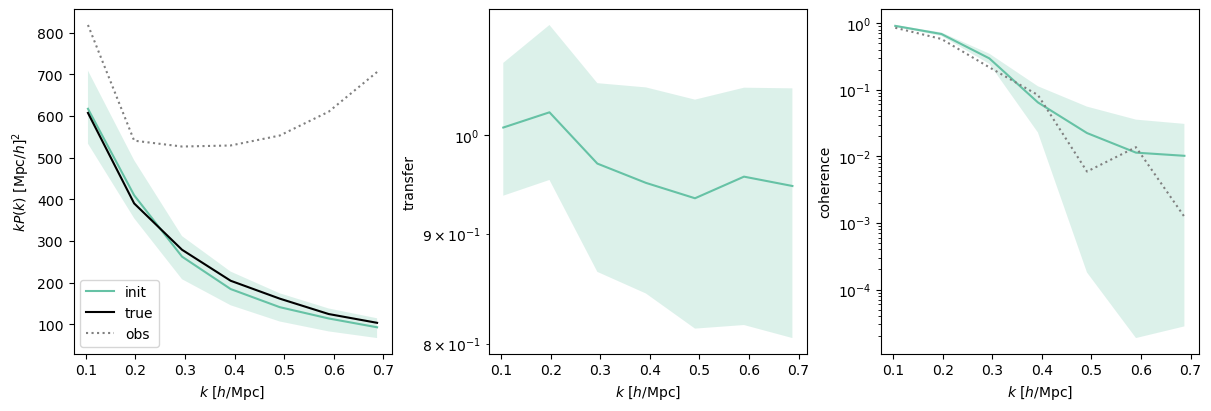

In [11]:
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
theme()
prob = 0.95
log = False

plt.figure(figsize=(12, 4), layout="constrained")
kptcs = tree.map(jnp.concatenate, chains['kptc'])
plot_powtranscoh(*jnp.median(jnp.stack(kptcs), 1), log=log, label='init')
plot_powtranscoh(*kptcs, log=log, fill=prob)

plt.subplot(131)
plot_pow(*pow0, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')
# NOTE: Power spectrum should converge close to the truth, 
# and coherence must be on the order of the coherence between truth and obs

Removed no burn in


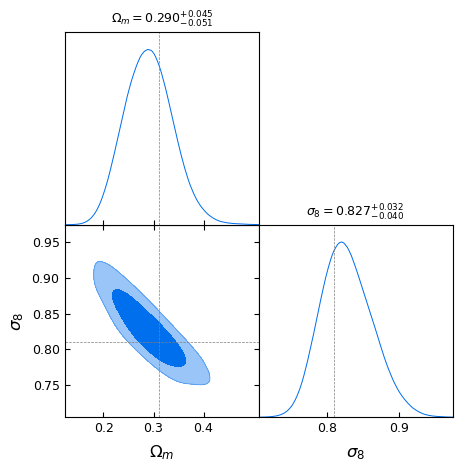

In [ ]:
# gdsamp = chains[['cosmo','bias']].to_getdist()
gdsamp = chains[['cosmo']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

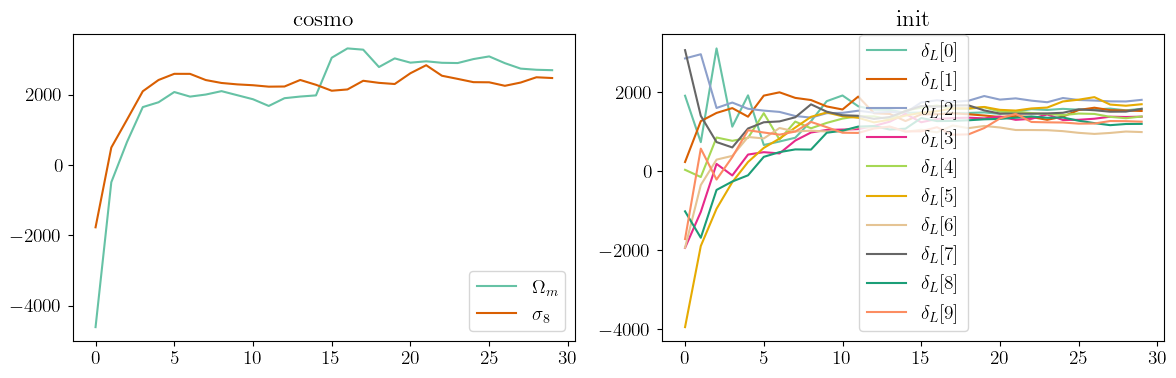

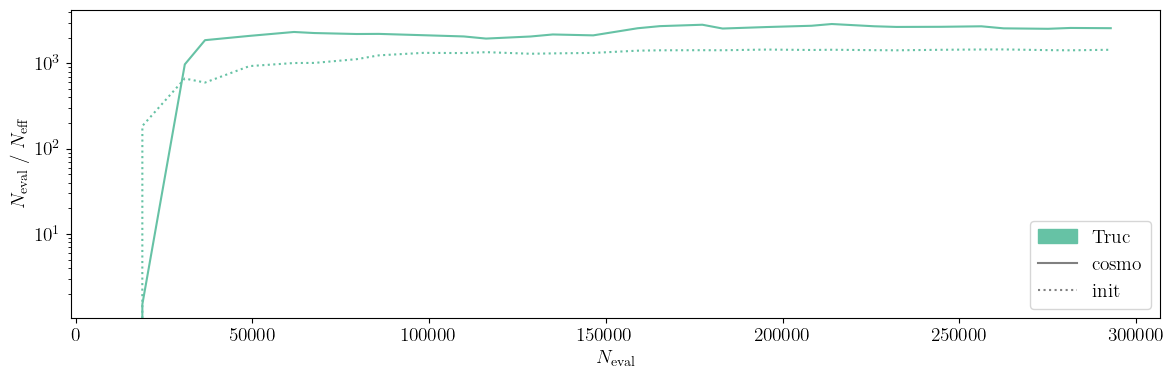

In [7]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(groups, 1)
plt.tight_layout()

metrics = []
cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")
plt.tight_layout();

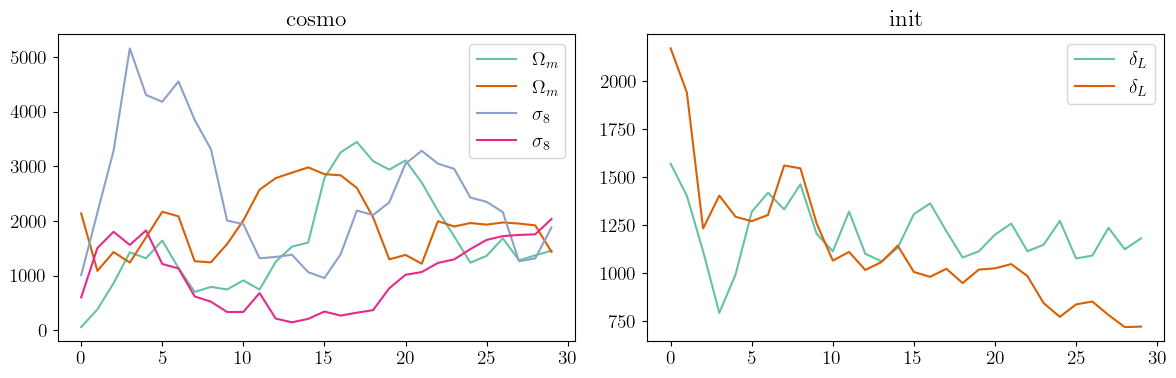

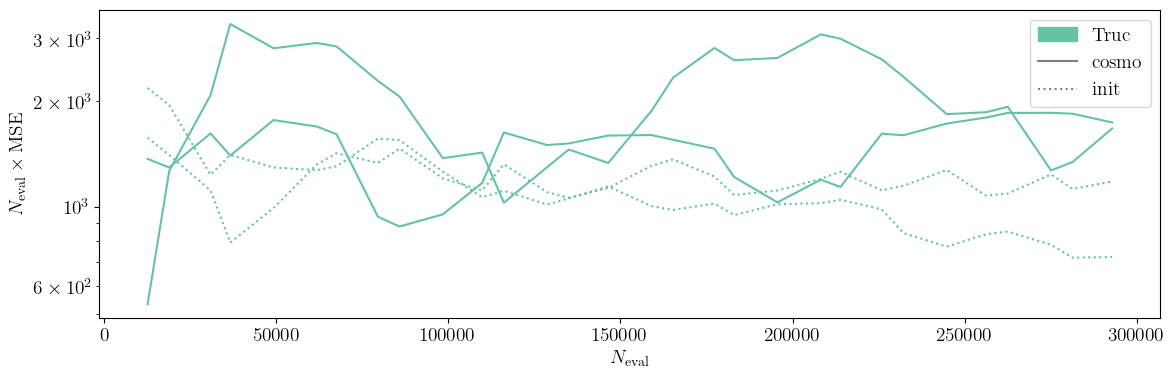

In [8]:
plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(groups, 1)
plt.tight_layout()

metrics = []
true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(groups).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$")
plt.tight_layout();

<Figure size 1200x400 with 0 Axes>

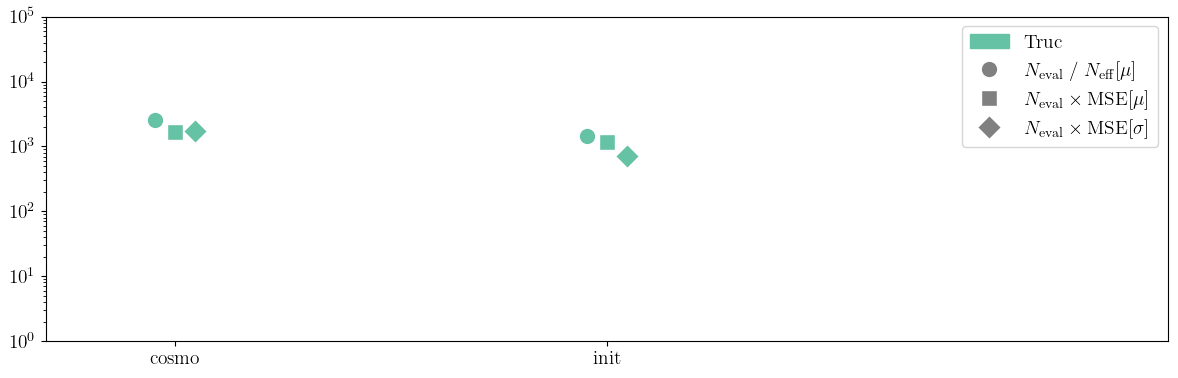

In [9]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(groups).eval_per_ess()
cummse = chains.stackby(groups).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
labels = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
    for i_g, g in enumerate(groups):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, label in enumerate(labels):
    handles.append(Patch(color=SetDark2(i_m), label=label))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right")
plt.tight_layout();

## Example


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.31      0.15      0.29      0.10      0.57     64.11      1.01
          b1      1.06      0.52      1.01      0.10      1.85     99.76      1.00
          b2      0.07      2.06      0.17     -3.59      2.94     89.42      1.00
         bn2     -0.30      1.78     -0.11     -3.40      2.19     87.39      1.00
         bs2      0.11      1.68     -0.02     -2.80      2.67    121.15      0.99
init_mesh[0]      0.10      1.70      0.25     -2.29      2.85    126.55      1.00
init_mesh[1]     -0.08      1.54     -0.13     -1.81      3.12    134.99      1.01
init_mesh[2]      0.07      1.59     -0.04     -2.74      2.50    119.47      0.98
init_mesh[3]     -0.11      1.49     -0.04     -2.75      1.88    207.53      1.00
init_mesh[4]     -0.05      1.81     -0.02     -2.85      3.22    127.23      0.99
init_mesh[5]     -0.33      1.46     -0.25     -2.38      2.12    113.33      0.99
ini

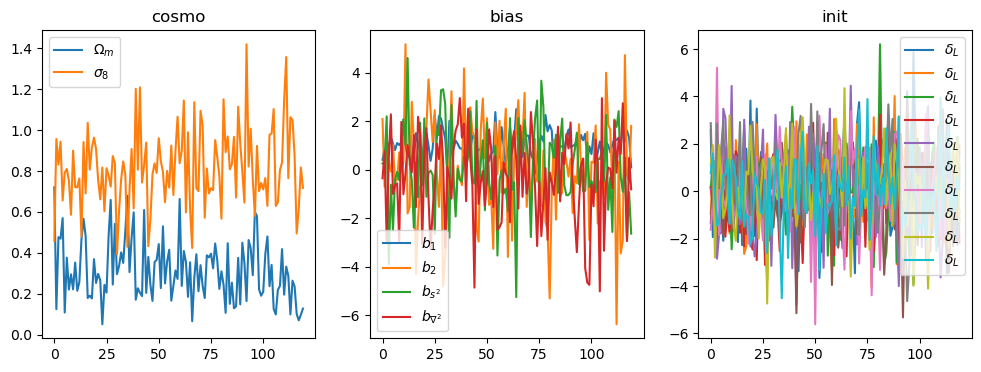

In [ ]:
plt.figure(figsize=(12,4))
chains.plot(groups)
chains.print_summary()

Removed no burn in


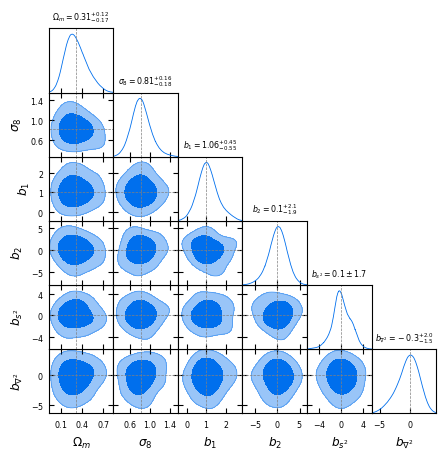

In [ ]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

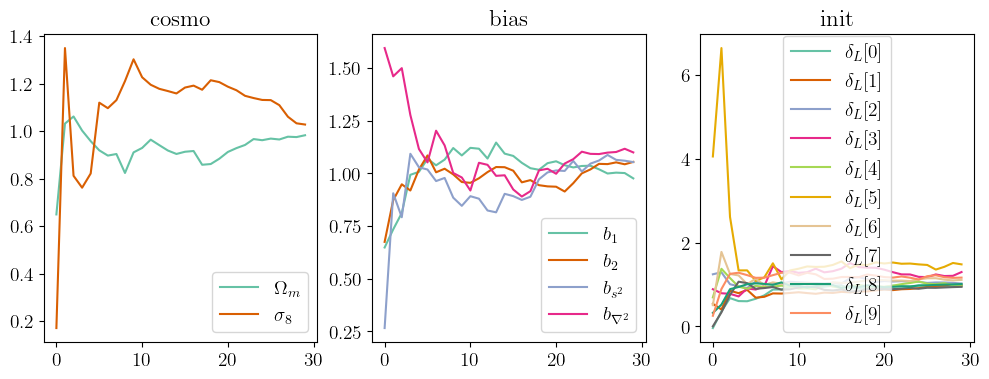

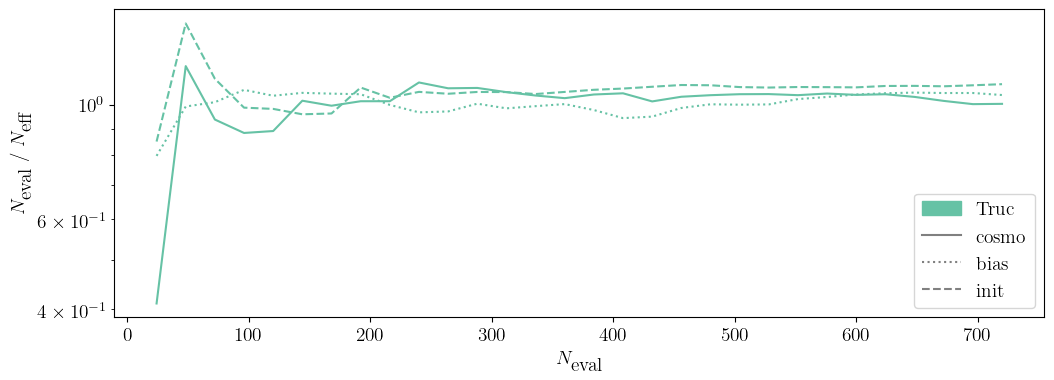

In [60]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(groups, 1)

metrics = []
cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

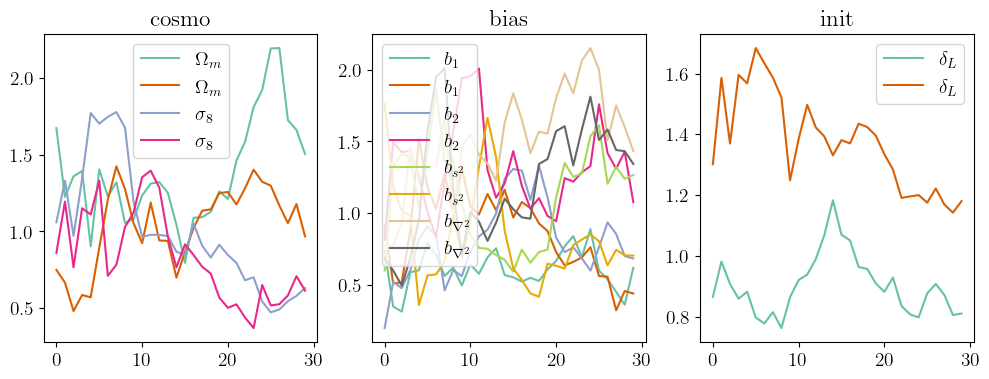

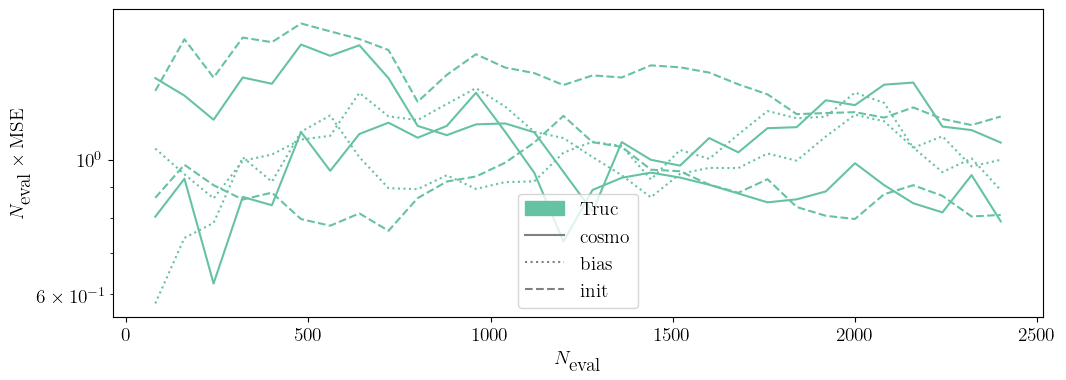

In [97]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)

plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(groups, 1)

metrics = []
true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(groups).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$");

<Figure size 1200x400 with 0 Axes>

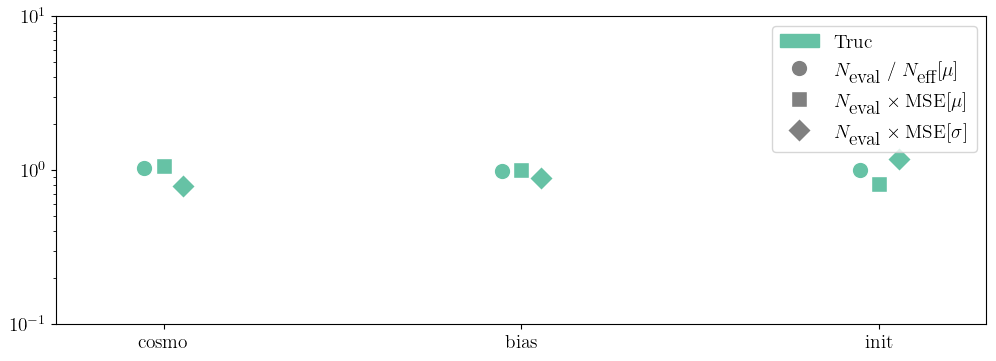

In [98]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(groups).eval_per_ess()
cummse = chains.stackby(groups).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
labels = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]
# metric_names = ["ESS", "MSE[$\\mu$]", "MSE[$\\sigma$]"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
    for i_g, g in enumerate(groups):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, label in enumerate(labels):
    handles.append(Patch(color=SetDark2(i_m), label=label))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right");

# Comparison

Loading: sNUTS_nc4_ns64_mt10_ta0.65, from run 0 to run 20 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/sNUTS_nc4_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 704), 'b1': (4, 704), 'b2': (4, 704), 'bn2': (4, 704), 'bs2': (4, 704), 'init_mesh': (4, 704, 10), 'n_evals': (4, 704), 'sigma8': (4, 704)}

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.33      0.02      0.33      0.30      0.37    120.11      1.03
          b1      1.01      0.05      1.01      0.92      1.09      8.73      1.35
          b2     -0.03      0.02     -0.03     -0.06      0.01     40.80      1.09
         bn2      0.26      0.24      0.25     -0.13      0.66     53.51      1.10
         bs2     -0.00      0.09     -0.00     -0.14      0.15     23.98      1.15
init_mesh[0]      2.41      1.35      2.39      0.24      4.69   1757.29      1.00
init_mesh[1]      0.32      1.33      0.30     -1.88      2.47   1906.35      1.00
init_mesh[2]      0.73      1.46      0.73     -1.74      3.05   1745.35      1.00
init_mesh[3]     -0.40      1.55     -0.39     -2.99      2.03   1645.03      1.00
init_mesh[4] 

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 704), 'b1': (4, 704), 'b2': (4, 704), 'bn2': (4, 704), 'bs2': (4, 704), 'init_mesh': (4, 704, 10), 'n_evals': (4, 704), 'sigma8': (4, 704)}

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.30      0.06      0.30      0.21      0.39     25.67      1.17
          b1      1.00      0.06      0.99      0.90      1.09     22.05      1.21
          b2     -0.03      0.03     -0.03     -0.07      0.01     57.82      1.10
         bn2      0.15      0.21      0.14     -0.21      0.48     75.74      1.05
         bs2     -0.03      0.09     -0.03     -0.18      0.13     32.86      1.14
init_mesh[0]      2.41      1.29      2.37      0.20      4.38   1311.26      1.00
init_mesh[1]      0.34      1.28      0.30     -1.75      2.41   2055.09      1.00
init_mesh[2]      0.70      1.44      0.71     -1.57      3.17   1145.75      1.00
init_mesh[3]     -0.43      1.54     -0.37     -2.78      2.22   1273.81      1.00
init_mesh[4] 

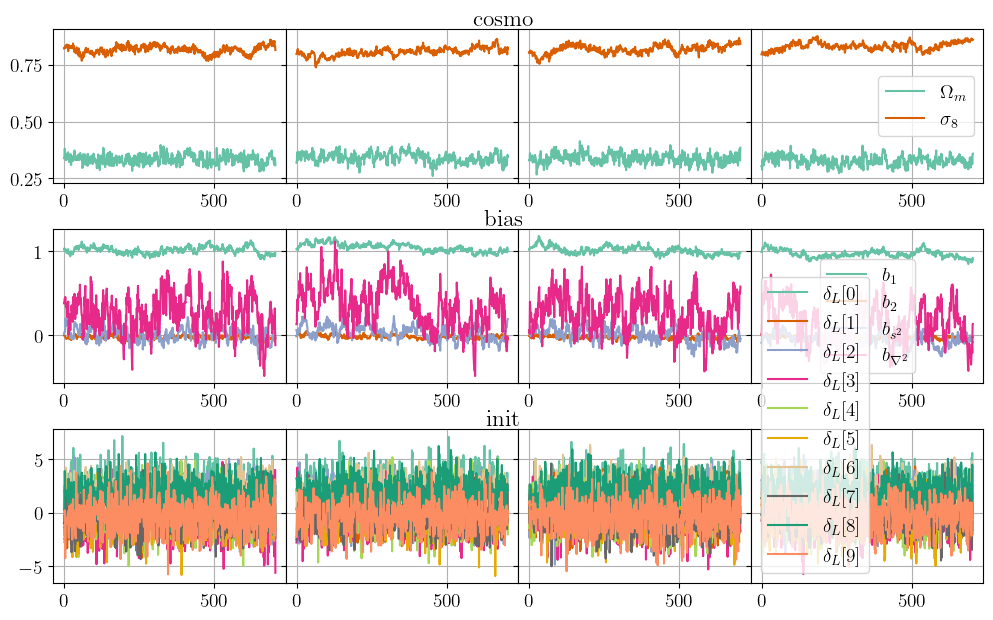

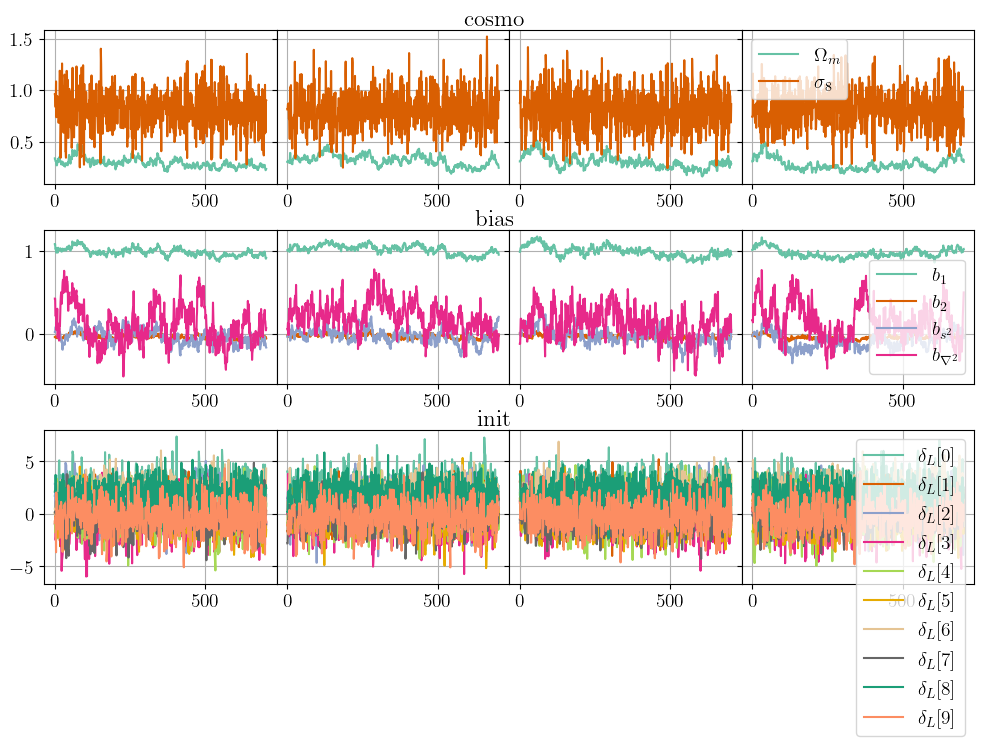

In [5]:
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=14)
groups = ['cosmo','bias','init']

# pfx = 'precond_m64_lo0_'
# tids = [3000,3010,3020,3030]

pfx = 'precond_m64_lo1_'
tids = [3100,3110,3120,3130,3140,3150,3160][4:-1]
labels = ['prior-direct', 'prior-fourier', 'static no bias', 'dynamic', 'dynamic no bias', 'static', 'static no bias'][4:-1]

# pfx = 'sampler_m64_lo0_'
# tids = [3030,3031,3032]

# pfx = 'sampler_m64_lo1_'
# tids = [3130,3131,3132]
# labels = ['NUTS', 'HMC', 'NUTSwG']

starts = [0, 0, 0, 0]
end = 20

moms = []
for start, tid, lab in zip(starts, tids, labels):
    model, mcmc_config, save_dir, save_path = from_id(tid)

    # Load chains
    transforms = [
              lambda x:x[['*~diverging']],
              partial(Chains.thin, thinning=1),
              model.reparam_chains,
              partial(Chains.choice, n=10, names=['init','init_']),
                ]
    chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
    print(chains.shape)

    # Load last state
    # last_state = pload(save_path + "_last_state.p")
    # print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)

    # Plot chains
    plt.figure(figsize=(12,6))
    chains.flatten().plot(groups)
    plt.savefig(save_dir+f'chains_{tid}.png')
    chains.print_summary()
    
    # Compute moments
    mom = chains.stackby(groups).moment(axis=(0,1))
    moms.append(mom)

true_cmom = tree.map(lambda *x: jnp.stack(x), *moms)
true_cmom = true_cmom.moment(m=1, axis=0).center_moment()
print("centered moments:", true_cmom)

In [ ]:
metrics = []
fin_metrics = []
gdsamps = []
kptcs = []
kptcs_obs = []
for start, tid, lab in zip(starts, tids, labels):
    model, mcmc_config, save_dir, save_path = from_id(tid)

    # Load truth
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")
    model.delta_obs = truth['obs'] - 1
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    pow0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

    # Load chains
    transforms = [
                lambda x: x[['*~diverging']],
                partial(Chains.thin, thinning=1), 
                model.reparam_chains, 
                partial(model.powtranscoh_chains, mesh0=mesh0),
                partial(Chains.choice, n=10, names=['init','init_']),
                ]
    chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
    print(chains.shape)

    # Compute mesh statistics
    kptc = tree.map(jnp.concatenate, chains.pop('kptc'))
    kptcs.append(kptc)
    
    # Compute metrics
    cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 50)
    metrics.append(cumess)

    cumess = chains.stackby(groups).eval_per_ess()
    # true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment() # local truth
    cummse = chains.stackby(groups).eval_times_mse(true_cmom)
    fin_metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
    fin_metrics.append(fin_metric)

    # Prepare KDE
    gdsamp = chains[['cosmo','bias']].to_getdist(lab)
    gdsamps.append(gdsamp)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/
Loading: sNUTS_nc4_ns64_mt10_ta0.65, from run 0 to run 20 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/sNUTS_nc4_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 704), 'b1': (4, 704), 'b2': (4, 704), 'bn2': (4, 704), 'bs2': (4, 704), 'init_mesh': (4, 704, 10), 'kptc': ((4, 704, 15), (4, 704, 15), (4, 704, 15), (4, 704, 15)), 'n_evals': (4, 704), 'sigma8': (4, 704)}
Removed no burn in
Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc5_obfield/
Loading: sNUTS_nc4_ns64_mt10_ta0.65, from run 0 to run 20 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc5_obfield/sNUTS_nc4_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 704), 'b1': (4, 704), 'b2': (4, 704), 'bn2': (4, 704), 'bs2': (4, 704), 'init_mesh': (4, 704, 10), 'kptc': ((4, 704, 15), (4, 704, 15), (4, 704, 15), (4, 704, 15)), 'n_evals': (4, 704), 'sigma8': (4, 704)}
Removed no burn in


In [7]:
def plot_traj_fn(metrics, labels):
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))
    plt.legend(handles=handles, loc='lower right')

    plt.xlabel("$N_{\\mathrm{eval}}$")
    # plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
    plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")

def plot_fin_fn(fin_metrics, labels):
    markers = ['o','s','D']
    ms = 12
    mec = 'w'
    ls = ""
    metric_names = [
                    "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                    # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                    "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                    "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]
    # metric_names = ["ESS", "MSE[$\\mu$]", "MSE[$\\sigma$]"]

    from matplotlib.transforms import ScaledTranslation
    offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData
    xshifts = 5*np.array([-1,0,1])
    plt.xlim(-.3,2.3)

    for i_m, (metric, meth) in enumerate(zip(fin_metrics, labels)):
        for i_g, g in enumerate(groups):
            for i_n, marker in enumerate(markers):
                plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                            linestyle=ls, markersize=ms, markeredgecolor=mec, 
                            transform=trans+offset(xshifts[i_n]),
                            )

    handles = []
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    for i_m, label in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=label))
    for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
        handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                            linestyle=ls, markersize=ms, markeredgecolor=mec))
    # plt.legend(handles=handles, loc="upper right")
    plt.legend(handles=handles, loc="lower left")

def plot_kptc(kptcs, labels):
    prob = 0.95
    log = False

    for kptc, label in zip(kptcs, labels):
        plot_powtranscoh(*jnp.median(jnp.stack(kptc), 1), log=log, label=label)
        plot_powtranscoh(*kptc, log=log, fill=prob)

    plt.subplot(131)
    plot_pow(*pow0, 'k', log=log, label='true')
    plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
    plt.legend()

    plt.subplot(133)
    plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')

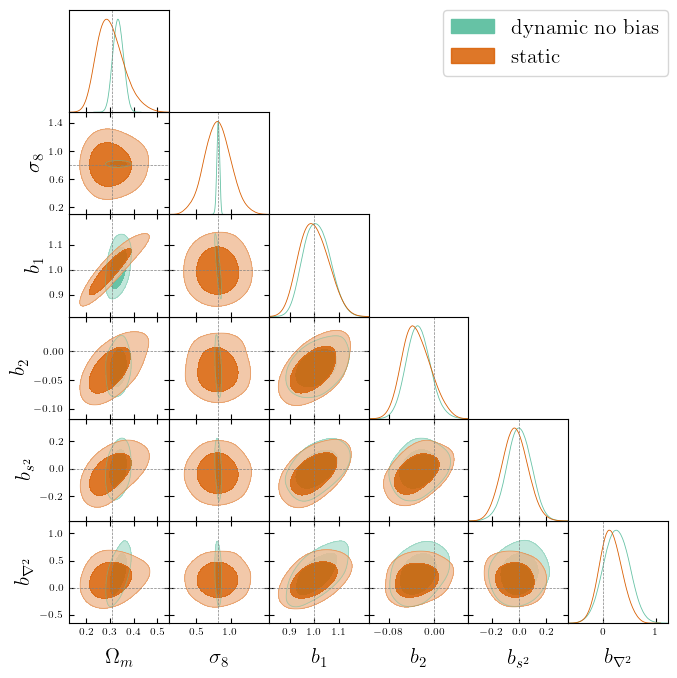

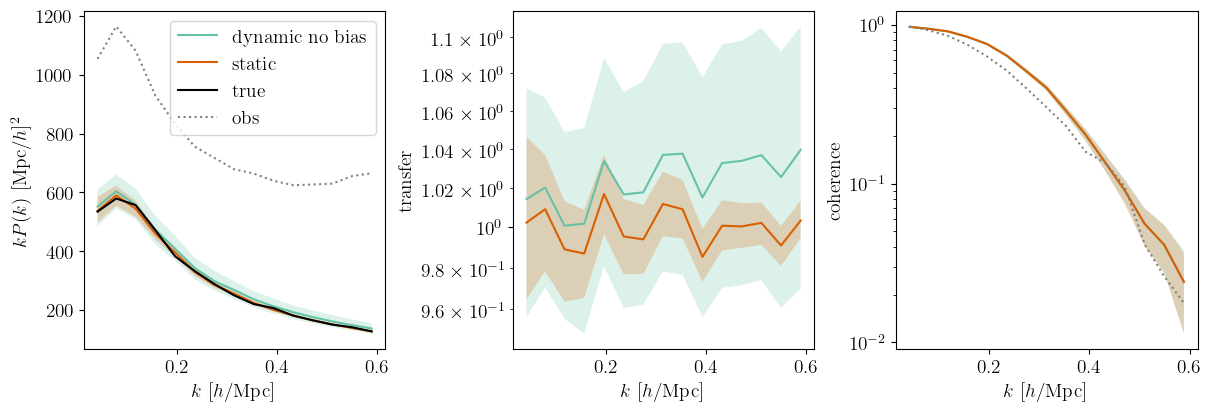

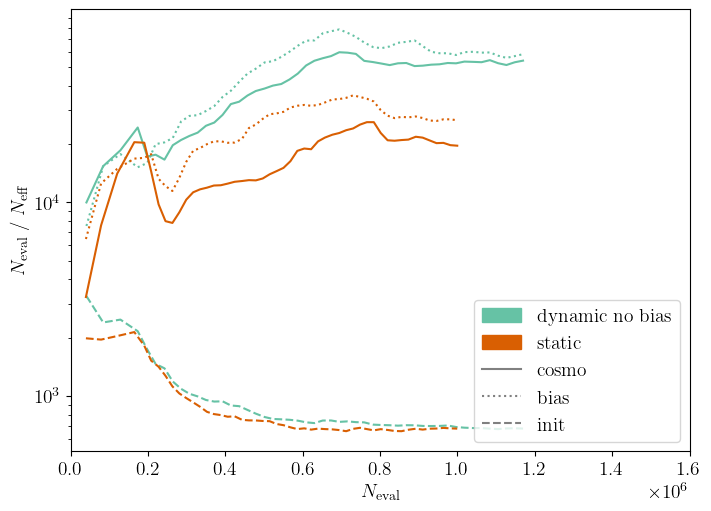

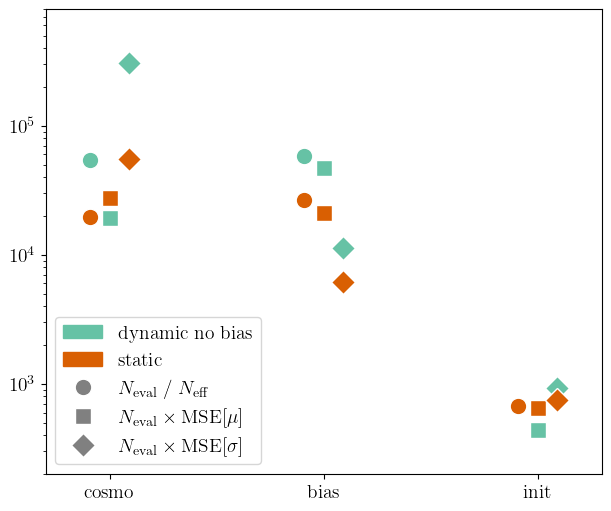

In [10]:
# Plot KDE, traj metrics, and final metrics
theme(usetex=True, font_size=14)

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.settings.legend_fontsize = 20
gdplt.settings.axes_labelsize = 20
gdplt.settings.axes_fontsize = 12
# gdplt.settings.figure_legend_frame = False
# gdplt.settings.num_plot_contours = 3
gdplt.triangle_plot(roots=gdsamps,
                # title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
                legend_loc='upper right',)
plt.savefig(pfx+'triangle.pdf')

plt.figure(figsize=(12, 4), layout="constrained")
plot_kptc(kptcs, labels)
plt.savefig(pfx+'kptc.pdf')

plt.figure(figsize=(7, 5), layout="constrained")
plot_traj_fn(metrics, labels)
plt.xlim(0,1.6e6)
plt.savefig(pfx+'cumess.pdf')

plt.figure(figsize=(6, 5), layout="constrained")
plot_fin_fn(fin_metrics, labels)
plt.ylim((2*1e2, 8*1e5))
plt.savefig(pfx+'fin_metrics.pdf')

# Misc.

In [56]:
shape = (4,60)
jfn = jit(partial(model.predict, samples=shape))
params = jfn(jr.key(42))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_0", **params)
params = jfn(jr.key(43))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_1", **params)
params = jfn(jr.key(44))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_2", **params)
save_path = save_dir+"samples"

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


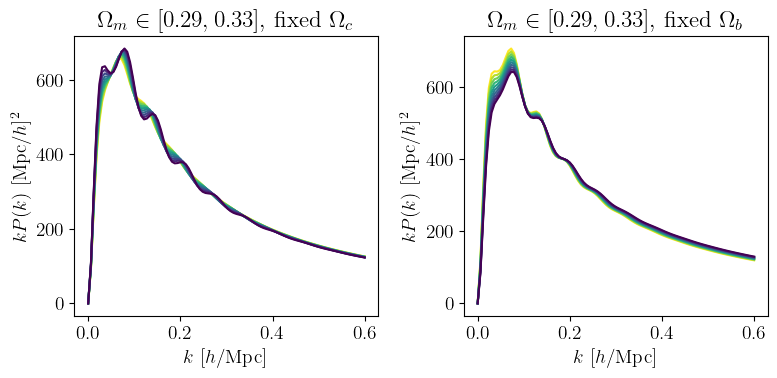

In [30]:
from montecosmo.bricks import Planck18
from montecosmo.plot import plot_pow
import jax_cosmo as jc

n = 10
a = 1.
log = False
ks = jnp.linspace(0, 0.6, 100)
pk_fn = jit(partial(jc.power.linear_matter_power, k=ks, a=a))
Oms = np.linspace(0.29, 0.33, n)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("$\\Omega_m \\in [0.29, 0.33]$, fixed $\\Omega_c$")
for i_c, Om in enumerate(Oms):
    cmap = plt.get_cmap('viridis_r', n)
    cosmo = Planck18(Omega_b=Om - Planck18().Omega_c)
    pk = pk_fn(cosmo)
    plot_pow(ks, pk, log=log, color=cmap(i_c))

plt.subplot(122)
plt.title("$\\Omega_m \\in [0.29, 0.33]$, fixed $\\Omega_b$")
for i_c, Om in enumerate(Oms):
    cmap = plt.get_cmap('viridis_r', n)
    cosmo = Planck18(Omega_c=Om - Planck18().Omega_b)
    pk = pk_fn(cosmo)
    plot_pow(ks, pk, log=log, color=cmap(i_c))
plt.tight_layout()